In [100]:
%load_ext autoreload
%autoreload 2

import os
import itertools

import pysam
import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

import sklearn.mixture
from sklearn.mixture import BayesianGaussianMixture

import sys
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from handygenome.igvhandle import IGVHandle
import handygenome.bameditor as bameditor
import handygenome.analysis.feature as libfeature

In [166]:
geneset_gr = libfeature.get_geneset_gr('hg19')

In [167]:
geneset_gr

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,external_name,logic_name,...,havana_version,tag,transcript_id,constitutive,ensembl_end_phase,ensembl_phase,exon_id,rank,ccdsid,protein_id
0,1,cpg,biological_region,10468,11240,1.3e+03,.,.,oe %3D 0.79,cpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Eponine,biological_region,10649,10657,0.999,+,.,NaN,eponine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Eponine,biological_region,10655,10658,0.999,-,.,NaN,eponine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Eponine,biological_region,10677,10687,0.999,+,.,NaN,eponine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Eponine,biological_region,10681,10689,0.999,-,.,NaN,eponine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2626588,Y,havana,exon,28779491,28779578,.,-,.,NaN,NaN,...,NaN,NaN,NaN,1,-1,-1,ENSE00001638296,2,NaN,NaN
2626589,Y,havana,exon,28780669,28780799,.,-,.,NaN,NaN,...,NaN,NaN,NaN,1,-1,-1,ENSE00001797328,1,NaN,NaN
2626590,Y,havana,pseudogene,59001390,59001635,.,+,.,NaN,havana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2626591,Y,havana,processed_pseudogene,59001390,59001635,.,+,.,NaN,NaN,...,1,basic,ENST00000431853,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
geneset_gr.Feature.unique()

array(['biological_region', 'pseudogene', 'processed_transcript', 'exon',
       'pseudogenic_transcript', 'lincRNA_gene', 'lincRNA', 'miRNA',
       'gene', 'mRNA', 'CDS', 'processed_pseudogene', 'three_prime_UTR',
       'five_prime_UTR', 'transcript', 'snRNA_gene', 'snRNA',
       'aberrant_processed_transcript', 'NMD_transcript_variant',
       'miRNA_gene', 'RNA', 'snoRNA_gene', 'snoRNA', 'rRNA_gene', 'rRNA',
       'nc_primary_transcript', 'C_gene_segment', 'J_gene_segment',
       'V_gene_segment', 'VD_gene_segment', 'mt_gene'], dtype=object)

In [223]:
gene_coords = libfeature.get_gene_exon_coords_fromgff(['PLCXD1'], geneset_gr, refver='hg19')

In [224]:
gene_coords

{'PLCXD1': {'chrom': 'X',
  'gene': range(192988, 220023),
  'is_forward': True,
  'canonical_transcript': 'ENST00000381657',
  'CDS': [range(200854, 200981),
   range(205399, 205536),
   range(207314, 207443),
   range(208165, 208321),
   range(209701, 209885),
   range(215763, 216002)],
  'exon': [range(197858, 198351),
   range(200833, 200981),
   range(205399, 205536),
   range(207314, 207443),
   range(208165, 208321),
   range(209701, 209885),
   range(215763, 220023)],
  'five_prime_UTR': [range(197858, 198351), range(200833, 200854)],
  'three_prime_UTR': [range(216002, 220023)]}}

In [25]:
igv = IGVHandle(60387)

In [37]:
# infile_path = '/home/users/yunah1029/HC08_nonPAR_VAF_TD_exon_utrs.tsv'
infile_path = '/home/users/yunah1029/HC08_AllGenes_exons_utrs_readInfo.tsv'

In [ ]:
df = pd.read_csv(infile_path, sep='\t')

In [13]:
bam_paths_bwa = dict()
topdir = '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/03_haplotypecaller/HC08/tmp'
for fname in os.listdir(topdir):
    if fname.endswith('.mark.split.rg.base.bam') and fname.startswith('HC'):
        sid = fname.split('.')[0]
        bam_paths_bwa[sid] = os.path.join(topdir, fname)

In [18]:
bam_paths_star = dict()
# topdir = '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/*sortedByCoord.out.bam'
topdir = '/home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star'
for fname in os.listdir(topdir):
    if fname.endswith('sortedByCoord.out.bam'):
        sid = fname.split('Aligned')[0]
        bam_paths_star[sid] = os.path.join(topdir, fname)

In [111]:
bams_star = {sid: pysam.AlignmentFile(bam_path) for sid, bam_path in bam_paths_star.items()}

[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-08Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-18Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-01Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-04Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/team_projects/hcolon_heterogeneity/01_LINE1/02_RNA/02_bam/HC08/star/HC08-14Aligned.sortedByCoord.out.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /home/users/team_

In [59]:
igv.new()
igv.load([bam_paths_star[sid]])

OK
OK


In [257]:
def draw_ax(ax, gene_coords, df, sid, gene_name):
    # ax1: depths

    subdf = df.loc[(df.variable == sid) & (df['Gene.refGene'] == gene_name),:]

    # snp depths
    width = 50
    ax.bar(subdf['POS'], subdf['RD'], width=width, color='k')
    ax.bar(subdf['POS'], subdf['AD'], bottom=subdf['RD'], width=width, color='red')
    ax.bar(subdf['POS'], subdf['OD'], bottom=(subdf['RD'] + subdf['AD']), width=width, color='cyan')

    # all position depths
    for rng, deptharray in depths[sid].items():
        ax.fill_between(list(rng), deptharray, color='0.9', alpha=0.8)

    # exon borders
    ymax = np.nanmax(
        list(itertools.chain(subdf['TD'], itertools.chain.from_iterable(depths[sid].values())))
    )
    ymin = -(ymax / 10)
    heights = dict()
    heights['CDS'] = -ymin
    heights['five_prime_UTR'] = heights['CDS'] / 3
    heights['three_prime_UTR'] = heights['CDS'] / 3
    for key, h in heights.items():    
        if key in gene_coords:
            ax.add_collection(mpl.collections.PatchCollection(
                [
                    mpl.patches.Rectangle(
                        (rng.start, ymin - (ymin + h) / 2), 
                        len(rng), 
                        h, 
                        facecolor='blue', 
                        fill=True,
                    )
                    for rng in gene_coords[key]
                ]
            ))
            
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(gene_coords['gene'].start, gene_coords['gene'].stop)

    # ax2: VAF
    ax2 = ax.twinx()
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y')
    vafs = subdf['AD'] / subdf['TD']
    vafs[vafs < 0.5] = 1 - vafs
    colors = np.repeat('blue', len(vafs))
    colors[np.where(vafs == 1)[0]] = 'red'
    ax2.scatter(subdf['POS'], vafs, c=colors, s=4, marker='o')

    td_nan_pos = subdf.loc[subdf['TD'].isna(), 'POS']
    if len(td_nan_pos) > 0:
        ax2.plot(
            td_nan_pos, 
            np.repeat(1, len(td_nan_pos)), 
            marker='x', linestyle='', markersize=4,
            color='tab:red',
        )

In [264]:
def makefig(depths, gene_name, gene_coords, df):
    fig, axs = plt.subplots(len(depths) + 1, 1, figsize=(30, 50), gridspec_kw=dict(hspace=0.5))
    # fig.tight_layout()
    axs[0].text(0.5, 0.5, gene_name, transform=axs[0].transAxes, size=20)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].spines[['top', 'bottom', 'left', 'right']].set_visible(False)

    for sid, ax in zip(sorted(depths.keys()), axs[1:]):
        ax.set_title(sid)
        draw_ax(ax, gene_coords, df, sid, gene_name)
    # fig.suptitle(f'gene name: {gene_name}', y=1, size=30)
    
    return fig

In [258]:
gene_name = 'PLCXD1'

In [259]:
gene_coords = libfeature.get_gene_exon_coords_fromgff([gene_name], geneset_gr, refver='hg19')[gene_name]
depths = {sid: bameditor.get_exon_depths(bam, gene_coords) for sid, bam in bams_star.items()}

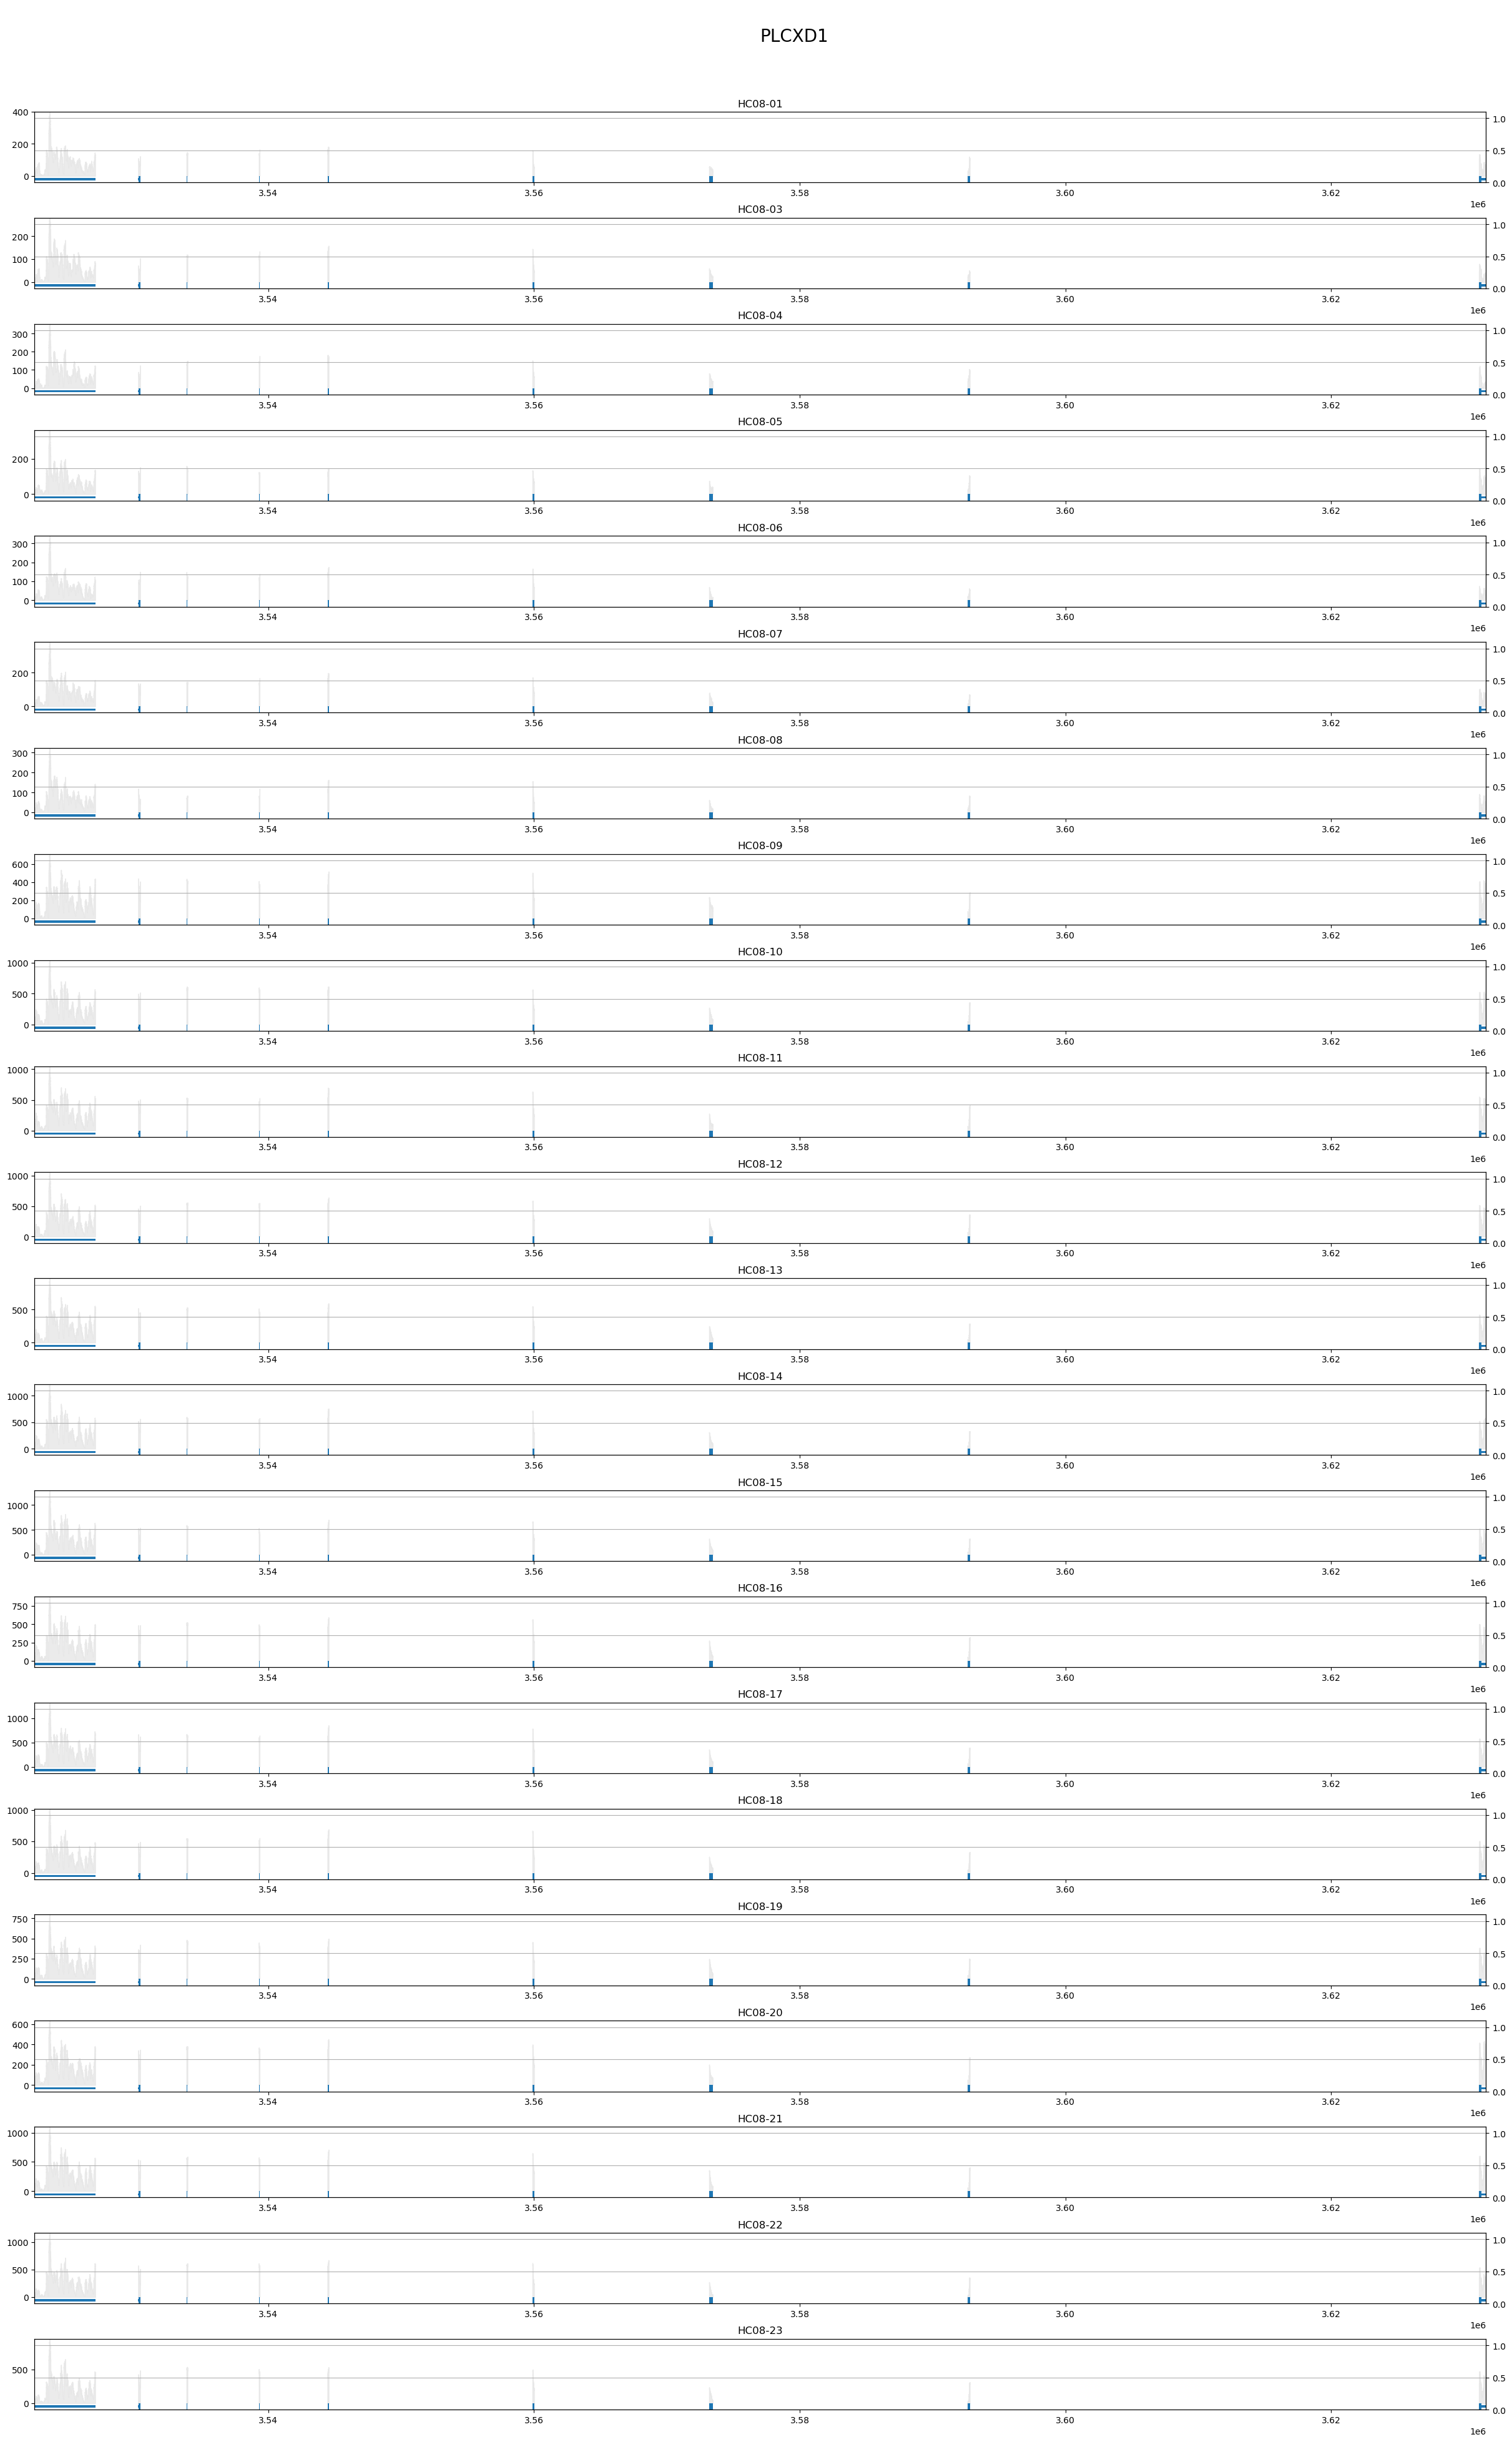

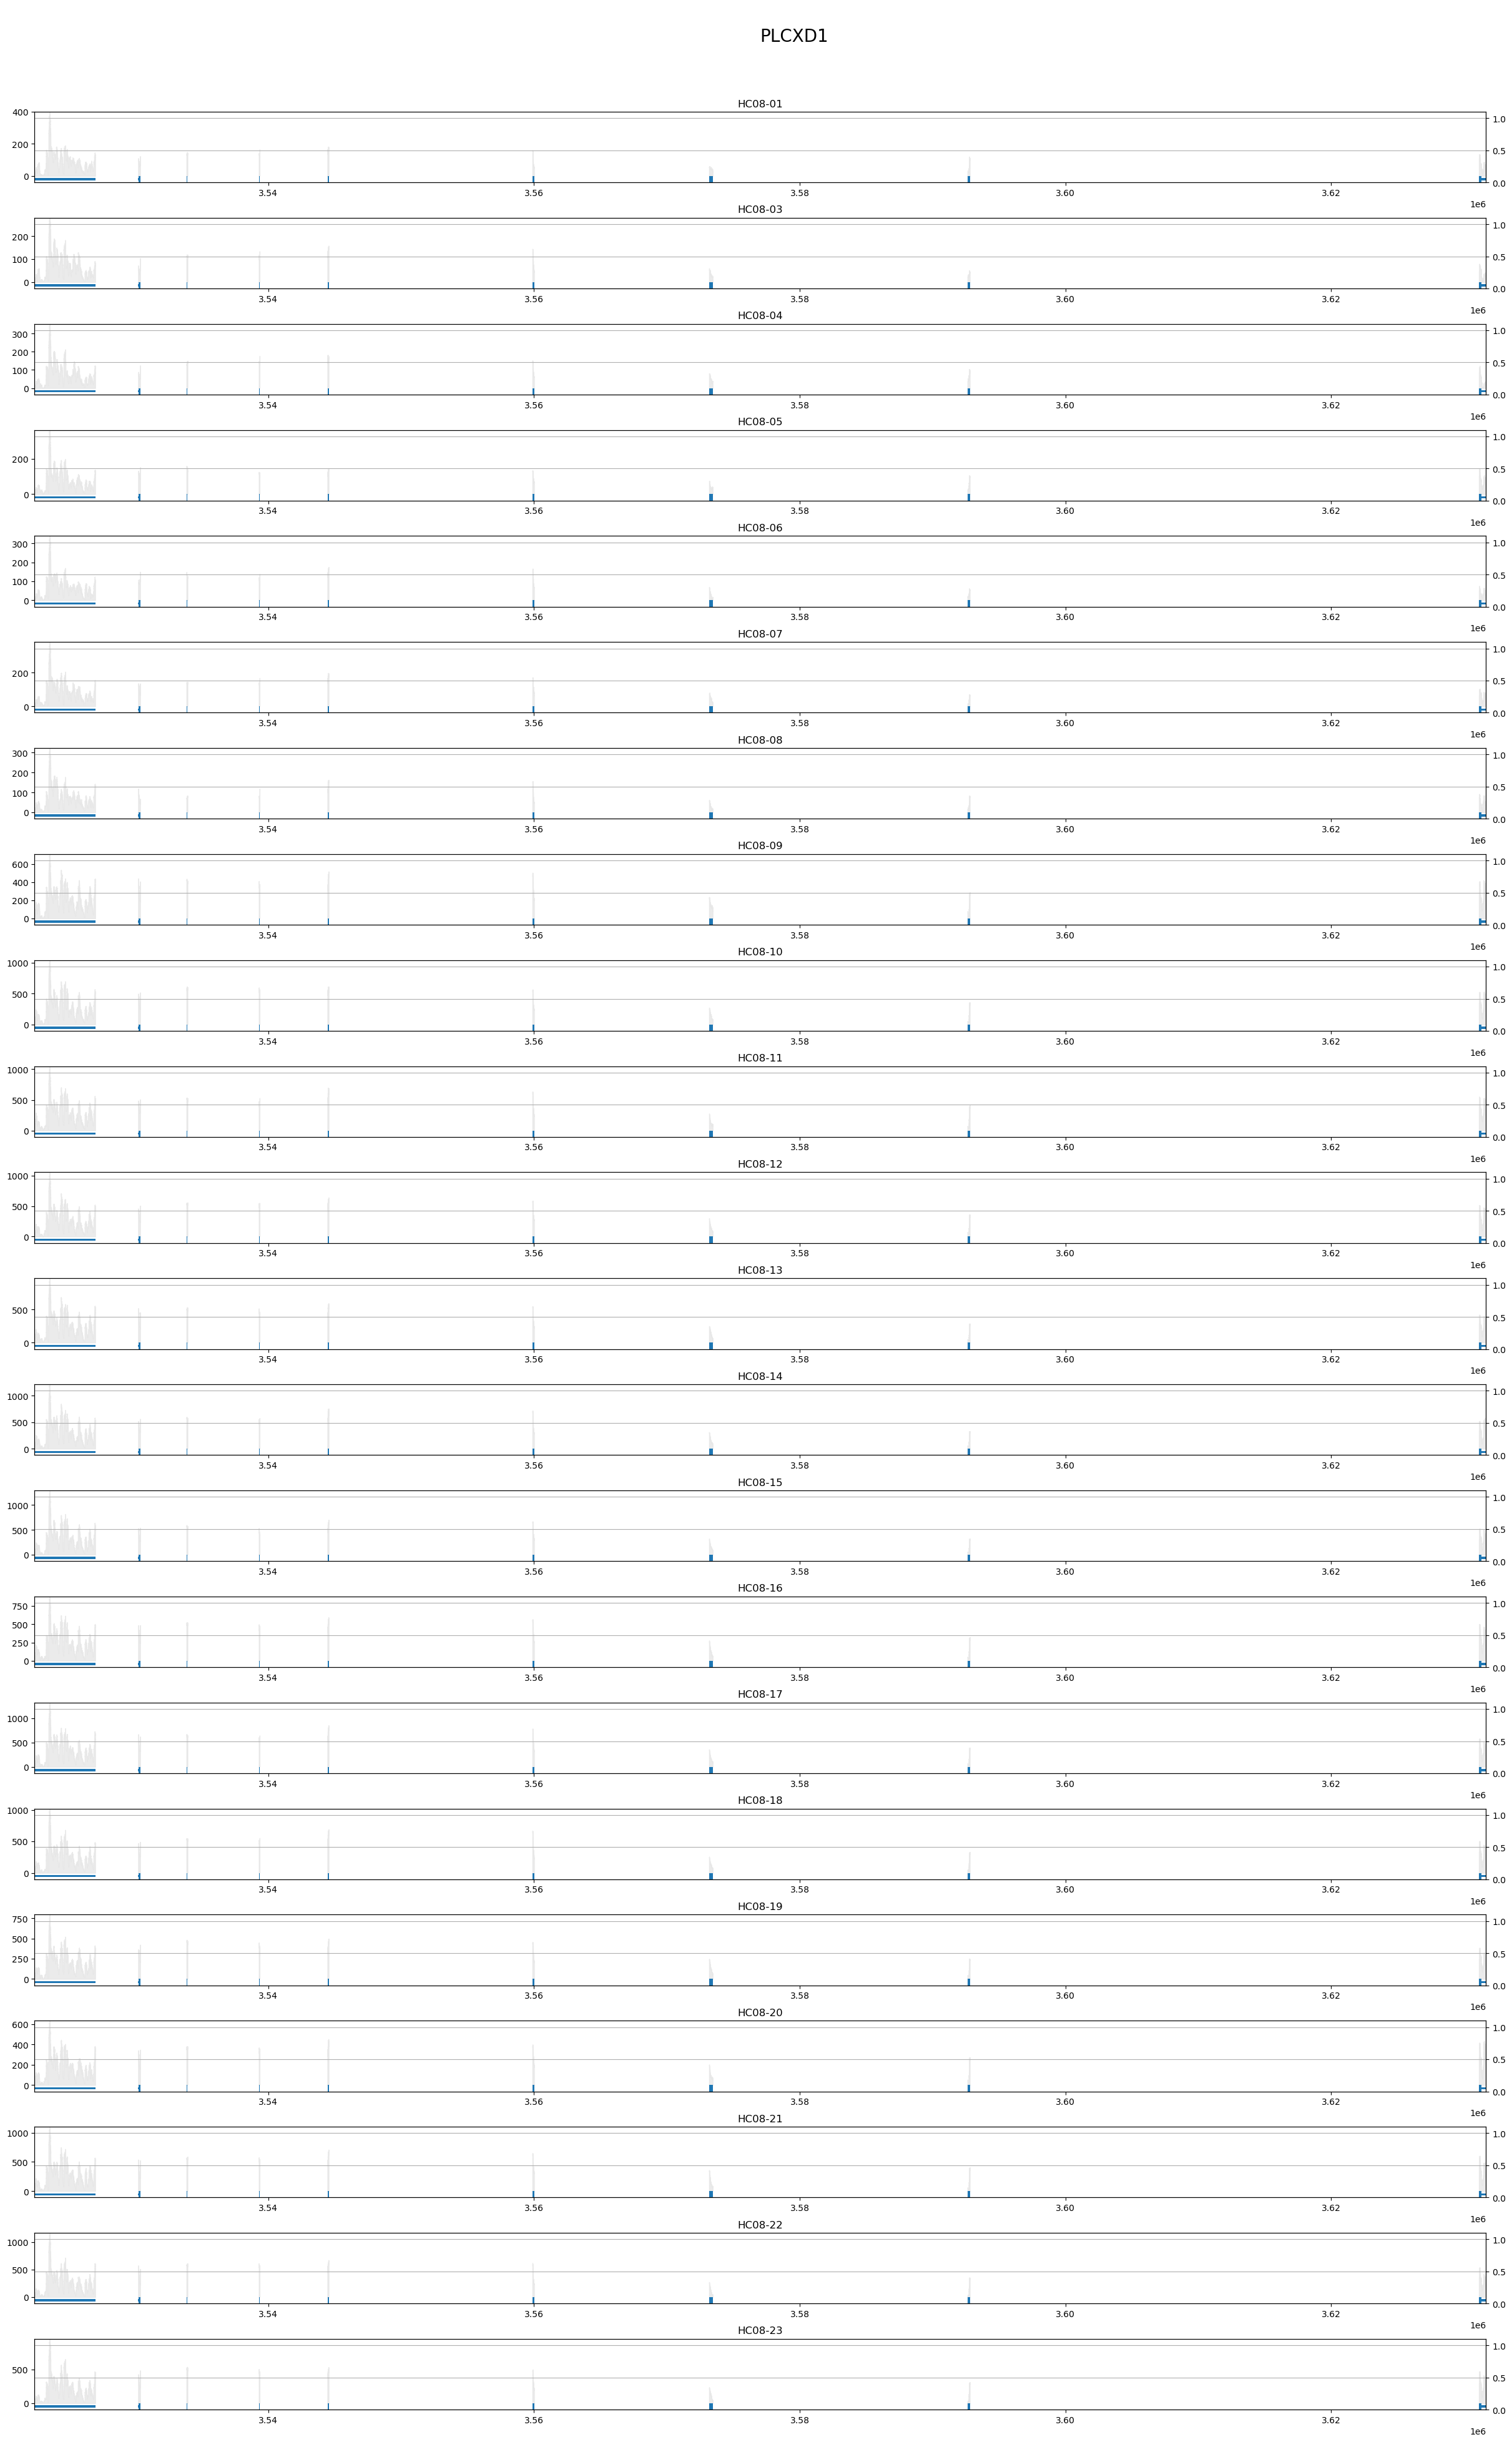

In [265]:
makefig(depths, gene_name, gene_coords, df)

In [261]:
figdir = '/home/users/pjh/yunahfigs/escape'
os.system(f'mkdir -p {figdir}')

0

In [ ]:
for genename in df['Gene.refGene'].unique():
    print(genename)
    
    fname = os.path.join(figdir, f'{genename}.pdf')
    
    gene_coords = libfeature.get_gene_exon_coords_fromgff([genename], geneset_gr, refver='hg19')[genename]
    depths = {sid: bameditor.get_exon_depths(bam, gene_coords) for sid, bam in bams_star.items()}
    
    fig = makefig(depths, genename, gene_coords, df)
    fig.savefig(fname)

In [4]:
df = pd.read_csv(infile_path, sep='\t')

In [5]:
newdf = df.copy()
newdf['ALT'] = np.rint(df.TD * df.VAF).astype(int)

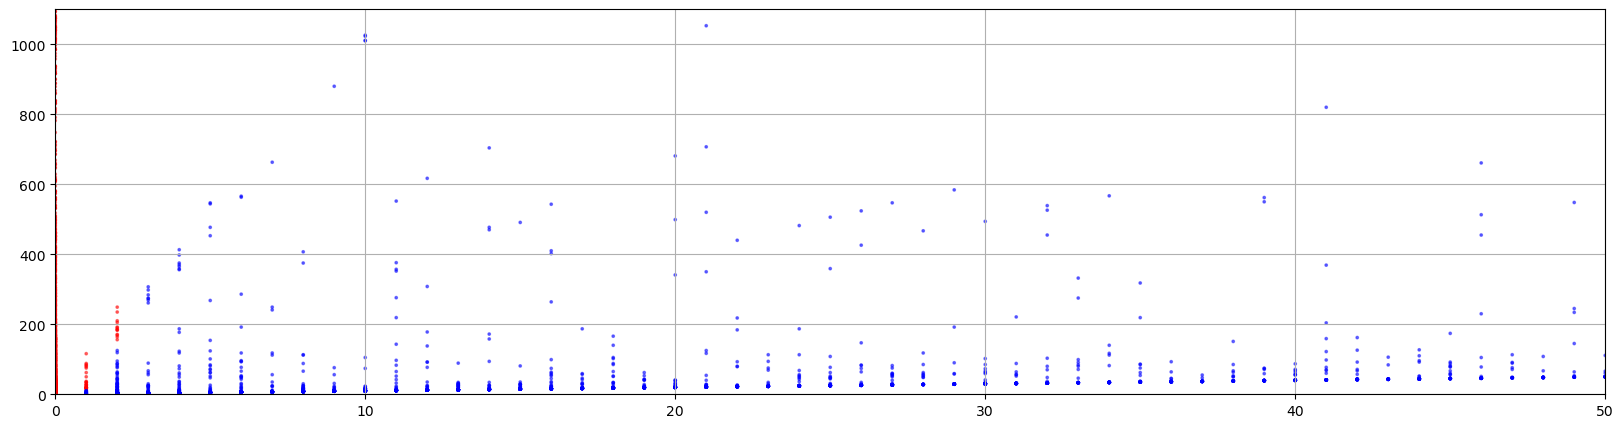

In [6]:
all_depths = newdf.TD.unique()
errorrate = 0.001
cutoffs_dict = dict(zip(
    all_depths, 
    scipy.stats.binom.ppf(q=0.99, n=all_depths, p=errorrate),
))
cutoffs = np.array([cutoffs_dict[x] for x in newdf['TD']])
newdf['passed'] = newdf['ALT'] > cutoffs
newdf['color'] = ['blue' if x else 'red' for x in newdf['passed']] 

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim(0, 2000)
ax.scatter(
    x=newdf['ALT'], 
    y=newdf['TD'], 
    c=newdf['color'],
    marker='o', 
    # linestyle='', 
    alpha=0.5, 
    s=3,
)

ax.set_xlim(0, 50)
ax.set_ylim(0, 1100)
# ax.set_xticks(np.arange(0, ax.get_xlim()[1]))
ax.grid()